# <center> **Предсказание оттока клиентов**
## <center> **Цели**
    
**1. Проанализировать данные и определить оптимальную методологию определения отточных клиентов**
    
**2. Разработать модель вероятности оттока клиентов по выбранной методологии**
    
**3. Дать интерпретацию разработанной модели, ответить на вопросы: какие признаки наиболее влияют на отток клиентов**

## Описание датасета:
* Чековые данные по транзакциям (transactions.parquet)

    * **chq_id:** ID of transaction (Primary key)
    * **plant:** ID of store (Foreign key for table plants)
    * **chq_date:** Date of transactions
    * **chq_position:** Position of material in transaction
    * **client_id:** ID of client (Foreign key for table clients)
    * **material:** ID of material (Foreign key for table materials)
    * **sales_count:** Count of item in the check position
    * **sales_sum:** Amount in the rubles by the check position
    * **is_promo:** Fact of slling the position of the check for promo
    
    
* Справочник товаров (materials.csv)

    * **plant** (Primary key)
    * **hier_level_1:** 1st level of items hierarchy
    * **hier_level_2:** 2nd level of items hierarchy
    * **hier_level_3:** 3rd level of items hierarchy
    * **hier_level_4:** 4th level of items hierarchy
    * **vendor:** Vendor of item
    * **is_private_label:** Own brand mark
    * **is_alco:** Sign of alcoholic beverages


* Справочник клиентов (clients.csv)

    * **client_id** (Primary key)
    * **gender**
    * **city**
    * **birthyear**


* Справочник магазинов (plants.csv)

    * **plant** (Primary key)
    * **plant_type**
    * **city**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf
import pyspark as ps
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .master('local') \
    .appName('jun DS') \
    .config('spark.executor.memory', '4gb') \
    .config('spark.executor.cores', '4')\
    .config("spark.cores.max", "6") \
    .config('spark.driver.memory','4g')\
    .getOrCreate()

# <center> 1. Определение отточных клиентов

**В рамках моего понимания решения задачи определения отточных клиентов, достаточно проанализировать данные по транзакциям покупателей, далее используя так скажем обоснованную "эвристику", определим тех клиентов, которые покинули рынок**

In [4]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
transactions = sqlContext.read.parquet('transactions.parquet')

In [5]:
transactions.printSchema()

root
 |-- chq_id: string (nullable = true)
 |-- plant: string (nullable = true)
 |-- chq_date: timestamp (nullable = true)
 |-- chq_position: string (nullable = true)
 |-- client_id: string (nullable = true)
 |-- material: string (nullable = true)
 |-- sales_count: double (nullable = true)
 |-- sales_sum: double (nullable = true)
 |-- is_promo: long (nullable = true)



In [6]:
transactions.count()

32109414

In [7]:
from pyspark.sql.functions import col, count, isnan, when

Проверим данные по транзакциям на наличие пропущенных значений.

In [8]:
transactions.select([count(when(col(c).isNull(), c)).alias(c) for c in transactions.columns]).show()

+------+-----+--------+------------+---------+--------+-----------+---------+--------+
|chq_id|plant|chq_date|chq_position|client_id|material|sales_count|sales_sum|is_promo|
+------+-----+--------+------------+---------+--------+-----------+---------+--------+
|     0|    0|       0|           0|        0|       0|          0|        0|       0|
+------+-----+--------+------------+---------+--------+-----------+---------+--------+



Описательная статистика

In [9]:
transactions.describe(['sales_count','sales_sum']).show()

+-------+------------------+------------------+
|summary|       sales_count|         sales_sum|
+-------+------------------+------------------+
|  count|          32109414|          32109414|
|   mean|1.3192295561980023|122.88696971533868|
| stddev|2.0153870890755163|250.20021159116604|
|    min|           -1656.0|          -98388.0|
|    max|            3000.0|          198571.5|
+-------+------------------+------------------+



Заметим, что существуют отрицательные значения по фактору (sales_sum), соответственно подобные транзакции принимаем за возврат, например клиент случайно приобрел товар, либо кассир ошибся и условно пробил один и тот же товар два раза. Данные не являются репрезентативными и не несут никакой информации.

In [10]:
transactions = transactions.filter('sales_sum >= 0')

Интересно будет узнать за какой период предоставлены данные

In [11]:
from pyspark.sql import functions as F

In [12]:
transactions\
    .agg(F.min('chq_date'), F.max('chq_date'))\
    .withColumnRenamed('min(chq_date)','Начало транзакций')\
    .withColumnRenamed('max(chq_date)','Конец транзакций')\
    .show()

+-------------------+-------------------+
|  Начало транзакций|   Конец транзакций|
+-------------------+-------------------+
|2016-10-04 03:00:00|2017-10-04 03:00:00|
+-------------------+-------------------+



Как видно из таблицы выше, в transaction хранится информация по транзациям за 1 год.

In [13]:
from pyspark.sql.functions import *

Создадим новые переменные. unix-timestamp и date (год-месяц-день), в дальнейшем они нам пригодятся

In [14]:
transactions = transactions\
                    .withColumn('unix', unix_timestamp(transactions.chq_date))

In [15]:
transactions = transactions\
                    .withColumn("date",to_date(col("chq_date"),"yyyy-MM-dd"))

По предоставленным данным нет разметки по клиентам, которые перестали посещать магазин. 
Первое, что приходит в голову, это посчитать промежутки между походами в магазин для каждого клиента и посмотреть на картину в целом.

In [16]:
# Будем считать, что если клиент в какой-то день побывал в магазине минимум 1 раз, то это считается за посещение.
# (т.к в течении дня он может побывать несколько раз)
# Посчитаем среднюю разницу в днях между посещениями для кжадого клиента,  преобразуем все в одномерное пр-во.

gaps = transactions\
            .select('client_id','date','unix')\
            .dropDuplicates(['client_id','date'])\
            .toPandas()\
            .sort_values(['client_id','unix'])\
            .groupby('client_id')['unix']\
            .apply(list)\
            .apply(np.diff)\
            .values

In [17]:
# Очевидно, что у тех клиентов, которые побывали в магазине только 1 раз, первая разница возвращает пустой лист,
# с помощью цикла избавимся от них.
# Завернем в пандасовскую серию для удобства.

gaps_list = []
for i in gaps:
    if i.shape[0] > 0:
        gaps_list.append(i.mean())
gaps_list = pd.Series(gaps_list)/(24*60*60)

Посмотрим на распределение, для понимания общей картины

<AxesSubplot:>

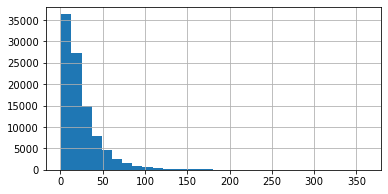

In [18]:
fig, axs = plt.subplots(figsize = (6,3))
gaps_list.hist(bins = 30)

<AxesSubplot:>

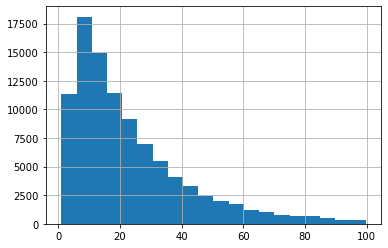

In [19]:
gaps_list[gaps_list < 100].hist(bins = 20)

Распределение имеет тяжелый правый хвост. В большинстве случаях между походами в магазин временной промежуток составляетот 1 до 40 дней.
Посмотрим значения квантилей уровней от 0.90 до 0.99

In [20]:
for q,v in  enumerate(np.round(gaps_list.quantile(np.arange(0.90,1,0.01)),2)):
    print(90+q,v)

90 54.17
91 56.8
92 59.6
93 63.5
94 68.0
95 73.25
96 81.0
97 89.25
98 105.33
99 137.0


Будем считать, что клиент больше не является нашим клиентом, если он отсутствует более чем 81 день (квантиль уровня 0.96)
Если брать 94-95-97 квантиль, точность модели падает и мной было принято решение, что 81 день достаточно оптимальный порог.

In [21]:
# Найдем верхнюю границу по времени для наших данных (2017-10-04 03:00:00) в формате unix-timestamp 

today = transactions.select('unix').agg({'unix':'max'}).collect()[0][0]

In [22]:
# Порог по времени. Если клиент отсутствовал более чем threshold_leave, считаем, что для такого клиент churn = True

threshold_leave = gaps_list.quantile(0.96)*24*60*60

Пусть сегодняшняя дата = 2017-10-04 03:00:00

Логично будет для каждого клиента определить последнюю дату визита, далее вычесть из сегодняшней даты (максимальный таймстемп по данным) дату последнего визита и сравнить с threshold_leave. То есть, если клиент не появлялся более чем 81 дней, будем считать, что он больше не вернется.

In [23]:
clients_churn = transactions\
                    .groupby('client_id')\
                    .agg(F.max('unix').alias('last_visit'))\
                    .withColumn("today",lit(today))\
                    .withColumn("lag",F.col('today') - F.col('last_visit'))\
                    .withColumn('churn',F.col('lag') > lit(threshold_leave))

In [24]:
clients_churn.show(5)

+--------------------+----------+----------+--------+-----+
|           client_id|last_visit|     today|     lag|churn|
+--------------------+----------+----------+--------+-----+
|eb09b11a1efb6e12f...|1496275200|1507075200|10800000| true|
|53acf04359f36317b...|1501718400|1507075200| 5356800|false|
|61d608187fef00a3d...|1503792000|1507075200| 3283200|false|
|41a98e24b9dc54df9...|1506729600|1507075200|  345600|false|
|d56ed3455ee141a02...|1481846400|1507075200|25228800| true|
+--------------------+----------+----------+--------+-----+
only showing top 5 rows



In [25]:
# Лишний раз убедимся, что во время преобразований данных, не потеряли ни одного клиента

clients_churn.count()

100000

In [26]:
# Посмотрим на соотношение тех кто ушел и тех кто остался.
#Видим, что около 28 процентов покупателей перестали быть нашими клиентами

clients_churn\
        .groupby('churn')\
        .agg(F.count('client_id'))\
        .show()


+-----+----------------+
|churn|count(client_id)|
+-----+----------------+
| true|           28105|
|false|           71895|
+-----+----------------+



**Задача предсказания оттока клиентов состоит в том, чтобы как можно раньше предсказать уйдет клиент или нет, с целью примения различных мер по его удержанию. 
Допустим мы хотим анализировать поведение покупателя за первые его два месяца посещения (63 дня) и сделать прогноз, останется он с нами или нет, а далее есть достаточное количество времени (около 20 дней, т.к трешолд в 81 день не есть истинное значение порога, может меньше/больше) для мер по его удержанию. ( удержать клиентов дешевле, чем привлечь новых)**

In [27]:
n = 63
time_analyse = n*24*60*60 # Время с первой покупки, за которое будем анализировать клиентов

In [28]:
from pyspark.sql.types import StringType, IntegerType, TimestampType


Создадим промежуточный df. Для каждого клиента определим его время с момента первой покупки + время за которое анализируем его поведение

In [29]:
# client_id = id клиента
# first_visit = первое посещение клиента
# life_time = первое посещение клиента + время за которое проводится анализ поведения покупателя (time_analyse)

client_time = transactions\
                    .select('client_id', 'unix')\
                    .groupby('client_id')\
                    .agg(F.min('unix').alias('first_visit'))\
                    .withColumn('life_time', F.col('first_visit') + lit(time_analyse))

In [30]:
# Замержим данные по транзакциям с client_time и возьмем только те данные,
# которые соответствуют времени с момента первой покупки + 63 дня

transactions_train = transactions\
                        .join(client_time, 'client_id', 'left')\
                        .filter(col('unix') <= col('life_time'))\
                        .drop('chq_position','life_time','date','chq_date')

**Таким образом, в transactions_train лежат все данные по транзациям клиентов за их первые 63 дня с момента, когда они совершили первую покупку в магазине (условно, на самом деле не для всех это утверждение верно, т.к данные за период 2016-10-04 по 2017-10-04 и некоторые клиенты могли совершать первые покупки еще до 2016-10-04, но предполагаю, что данные предоставлены только для новых уникальных клиентов с 2016-10-04)**

# <center> 2. Data preprocessing - Model - Testing

**На данном этапе будут генерироваться факторы и анализироваться тестовые модели, все шаги будут последовательные. Новые фичи -> Модель -> Проверка качества -> Добавление новых переменных -> Модель -> Проверка качества и так рекурентно**

На данном этапе работы пора уже собирать данные для построения вероятностной модели оттока. (генерить фичи и т.п)

### 2.1 Clients data 

In [31]:
client_train = clients_churn\
                    .select('client_id','churn')

Данные по клиентам

In [32]:
clients = spark.read.csv('clients.csv', header=True, inferSchema=True) 

In [33]:
# Добавим данные по клиентам в трейн датасет

client_train = client_train.join(clients,'client_id', 'left')

In [34]:
client_train.select([count(when(col(c).isNull(), c)).alias(c) for c in client_train.columns]).show()

+---------+-----+------+----+---------+
|client_id|churn|gender|city|birthyear|
+---------+-----+------+----+---------+
|        0|    0|   360|   5|     1781|
+---------+-----+------+----+---------+



**Видно, что в признаках gender, city, birthyear есть пропуски. Скорее всего те, кто не долго собираются оставаться на рынке, не заполняют свои данные, соответственно заменим пропущенные значения на "none"**

Следовательно будет логично для каждый пропуск в переменной gender заменить на gender ='none_g' 

In [35]:
client_train = client_train.fillna('none_g', subset = ['gender'])

Переменную churn преобразуем следующим образом:

In [36]:
from pyspark.sql.functions import col , udf

churn_dict = {False : 0, True : 1}

map_func = udf(lambda row : churn_dict.get(row,row), IntegerType())

client_train = client_train.withColumn("churn", map_func(col("churn")).cast(IntegerType()))

Пропуски в переменной city заменим на none_city

In [37]:
client_train = client_train.fillna('none_city', subset = ['city'])

Есть смысл преобразовать признак birthyear в возраст, а далее разбить на группы:

**От 0 до 25 = young**

**От 26 до 40 = middle**

**От 41 до 63 = mature**

**От 64 и более = old**

In [38]:
today_year = 2017.0

In [39]:
def age_group(x):
    return np.where(x==0, 'none_age', 
                    np.where(x <= 25, 'young', 
                             np.where(x <= 40, 'middle', 
                                      np.where(x<= 63,'mature','old')))).item()

In [40]:
age_group_udf = udf(age_group,StringType())

client_train = client_train\
                    .fillna(today_year, subset = ['birthyear'])\
                    .withColumn('age',lit(today_year) - F.col('birthyear'))\
                    .withColumn('age_group',age_group_udf(F.col('age')).cast(StringType()))\
                    .drop('birthyear','age')

**Посмотрим на распределения факторов в зависимости от churn**

In [41]:
client_train_df = client_train.toPandas()

In [42]:
# age_group
age_group_distribution = client_train_df\
                                .groupby('churn')\
                                .age_group\
                                .value_counts(normalize = True)\
                                .to_frame()\
                                .rename(columns = {'age_group':"percent"})\
                                .reset_index()\
                                .pivot(index = 'churn', columns = 'age_group',values = 'percent')\
                                .round(3)
age_group_distribution

age_group,mature,middle,none_age,old,young
churn,,,,,
0,0.385,0.395,0.016,0.087,0.117
1,0.354,0.369,0.022,0.111,0.145


In [43]:
# city
city_distribution = client_train_df\
                            .groupby('churn')\
                            .city\
                            .value_counts(normalize = True)\
                            .to_frame()\
                            .rename(columns = {'city':"percent"})\
                            .reset_index()\
                            .pivot(index = 'churn', columns = 'city',values = 'percent')\
                            .round(3)
city_distribution

city,Moscow,Other,St. Petersburg,none_city
churn,,,,
0,0.050,0.808,0.142,0.0
1,0.065,0.822,0.113,0.0


In [44]:
# gender
gender_distribution = client_train_df\
                            .groupby('churn')\
                            .gender\
                            .value_counts(normalize = True)\
                            .to_frame()\
                            .rename(columns = {'gender':"percent"})\
                            .reset_index()\
                            .pivot(index = 'churn', columns = 'gender',values = 'percent')\
                            .round(3)
gender_distribution

gender,F,M,none_g
churn,,,
0,0.593,0.404,0.003
1,0.592,0.402,0.005


**Из вышепредоставленных таблиц, видно, что распределения по трем сгенерированным факторам не сильно меняются в зависимости от значения churn для клиента, все таки есть смысл их использовать для построения вероятностой модели, но большого влияния от этих переменных ожидать не стоит**

Попробуем посмотреть на распределение конъюнкции признаков (gender, city, age_group) в зависимости от значения churn

In [45]:
client_train_df['gender_age'] = client_train_df['gender'] + '_' + client_train_df['age_group']

In [46]:
client_train_df['gender_city'] = client_train_df['gender'] + '_' + client_train_df['city']

In [47]:
client_train_df['age_city'] = client_train_df['age_group'] + '_' + client_train_df['city']

In [48]:
client_train_df\
            .groupby('churn')\
            .age_city\
            .value_counts(normalize = True)\
            .to_frame()\
            .rename(columns = {'age_city':'percent'})\
            .reset_index()\
            .pivot(index = 'churn',columns = 'age_city',values = 'percent')\
            .round(3)

age_city,mature_Moscow,mature_Other,mature_St. Petersburg,middle_Moscow,middle_Other,middle_St. Petersburg,none_age_Moscow,none_age_Other,none_age_St. Petersburg,none_age_none_city,old_Moscow,old_Other,old_St. Petersburg,young_Moscow,young_Other,young_St. Petersburg
churn,,,,,,,,,,,,,,,,
0,0.021,0.305,0.059,0.018,0.325,0.052,0.000,0.013,0.003,0.0,0.007,0.064,0.016,0.004,0.101,0.012
1,0.025,0.288,0.041,0.022,0.307,0.039,0.001,0.017,0.004,0.0,0.011,0.083,0.017,0.006,0.127,0.011


In [49]:
client_train_df\
            .groupby('churn')\
            .gender_city\
            .value_counts(normalize = True)\
            .to_frame()\
            .rename(columns = {'gender_city':'percent'})\
            .reset_index()\
            .pivot(index = 'churn',columns = 'gender_city',values = 'percent')\
            .round(3)

gender_city,F_Moscow,F_Other,F_St. Petersburg,M_Moscow,M_Other,M_St. Petersburg,none_g_Moscow,none_g_Other,none_g_St. Petersburg,none_g_none_city
churn,,,,,,,,,,
0,0.031,0.486,0.076,0.019,0.320,0.065,0.0,0.003,0.0,0.0
1,0.040,0.491,0.061,0.024,0.326,0.052,0.0,0.005,0.0,0.0


In [50]:
client_train_df\
            .groupby('churn')\
            .gender_age\
            .value_counts(normalize = True)\
            .to_frame()\
            .rename(columns = {'gender_age':'percent'})\
            .reset_index()\
            .pivot(index = 'churn',columns = 'gender_age',values = 'percent')\
            .round(3)

gender_age,F_mature,F_middle,F_none_age,F_old,F_young,M_mature,M_middle,M_none_age,M_old,M_young,none_g_mature,none_g_middle,none_g_none_age,none_g_old,none_g_young
churn,,,,,,,,,,,,,,,
0,0.242,0.215,0.009,0.063,0.064,0.143,0.179,0.006,0.024,0.052,0.0,0.000,0.002,NaN,0.000
1,0.221,0.201,0.011,0.084,0.076,0.132,0.167,0.008,0.027,0.067,0.0,0.001,0.003,0.0,0.001


**Из вышепредоставленных таблиц, видно, что конъюнкция признаков значительного изменения не дала, соответственно нет большого смысла их использовать в дальнейшем**

### 2.2 Plants data

In [51]:
# Данные по магазинам

plants = spark.read.csv('plants.csv', header=True, inferSchema=True) 

Сгенерируем факторы для трейн датасета, используя данные по магазинам.

Для каждого клиента определим. 

**сity_store** - город в котором клиент чаще всего совершает покупки. (Возможно, город каким-то образом влияет на таргет)

**plant_type** - тип магазина, который клиент чаще всего посещает. (Предположение следующее, вероятность оттока ниже, в случае, если клиент посещает чаще гипермаркет, нежели супермаркет)

**city_store_city** - **1** если город покупателя совпадает с городом где чаще всего делает закупки, **0** иначе

In [52]:
# сity_store

import pyspark.sql.functions as F
@F.udf

def mode(x):
    from collections import Counter
    return Counter(x).most_common(1)[0][0]

agg_expr = [mode(F.collect_list('city')).alias('city_store')]

city_store = transactions_train\
                    .select('client_id','plant','chq_id')\
                    .distinct()\
                    .join(plants,'plant','left')\
                    .select('client_id','city')\
                    .groupby("client_id")\
                    .agg(*agg_expr)

In [53]:
# Добавим данные по самому предпочтаемому городу в трейн датасет

client_train = client_train.join(city_store,'client_id', 'left')

In [54]:
# plant_type

agg_expr = [mode(F.collect_list('plant_type')).alias('plant_type')]

plant_type= transactions_train\
                    .select('client_id','plant','chq_id')\
                    .distinct()\
                    .join(plants,'plant','left')\
                    .select('client_id','plant_type')\
                    .groupby("client_id")\
                    .agg(*agg_expr)

# Добавим данные по самому предпочитаемому типу магазина в трейн датасет

client_train = client_train.join(plant_type, 'client_id', 'left')

In [55]:
## city_store_city 
client_train = client_train\
                    .withColumn('city_store_city',map_func(F.col('city') == F.col('city_store')).cast('Int'))

### 2.3 Transaction data

Разобьем первые 63 дня с момента первой покупки на 9 периодов, все периоды включают 7 дней. Каждой транзакции клиента поставим в соотвествие период в который была совершена покупка, то есть 1 неделя после первой покупки, 2 неделя после первой покупки и т.д. Смысл в том, что так будет проще анализировать поведения покупателя. Например будет полезно проанализировать как ведет себя покупатель со временем, повышается его посещаемость или остается на прежнем уровне, либо если падает его средний чек, то это скорее говорит о том, что он перестанет быть клиентом.

Почему берется неделя как 1 период. Проанализировав график средней посещаемости покупателей от дня года, можно заметить периодичность, скорее всего она вызвана временем года, месяцем, неделей года и днем недели.

Особую информаци несет зависимость количества уникальных посетителей от дня недели.С начала понедельника посещаемость падает, к выходным она растет, поэтому анализ поведение покупателя за 1 полную неделю, как-то его в целом характеризует, и периоды можно сравнивать между собой, так как они более менее равноценны между собой по полезности информации о клиенте.

In [56]:
# Вспомогательная таблица по уникальным клиентам, в зависимости от дня года, недели года и дню недели
n_clients_per_date = transactions\
                        .groupby('date')\
                        .agg(countDistinct('client_id'))\
                        .toPandas()

n_clients_per_date['date'] = n_clients_per_date['date'].apply(pd.to_datetime)
n_clients_per_date = n_clients_per_date\
                                .sort_values('date')\
                                .rename(columns = {'count(client_id)':'uniq_clients'})

n_clients_per_date['week_number'] = n_clients_per_date['date'].apply(lambda x: x.weekofyear)
n_clients_per_date['weekday'] = n_clients_per_date['date'].apply(lambda x: x.weekday())

In [57]:
# Количество уникальных посетителей в зависимости от недели года
n_clients_per_week = n_clients_per_date\
                            .groupby('week_number')\
                            .agg({"uniq_clients":'sum'})\
                            .sort_values('week_number')

In [58]:
# Количество уникальных посетителей в зависимости от дня недели
n_clients_per_weekday = n_clients_per_date\
                            .groupby('weekday')\
                            .agg({"uniq_clients":'sum'})\
                            .sort_values('weekday')

<AxesSubplot:xlabel='date', ylabel='uniq_clients'>

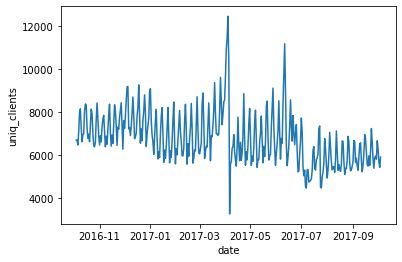

In [59]:
plt.figsize = (15,7)

#График зависимости количества уникальных посетителей от дня года
sns.lineplot(x = 'date', y = 'uniq_clients',data =n_clients_per_date)

<AxesSubplot:xlabel='week_number', ylabel='uniq_clients'>

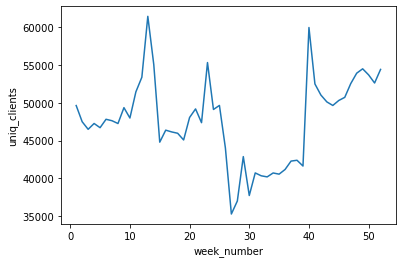

In [60]:
#График зависимости количества уникальных посетителей недели года
sns.lineplot(x = 'week_number', y = 'uniq_clients', data = n_clients_per_week)


<AxesSubplot:xlabel='weekday', ylabel='uniq_clients'>

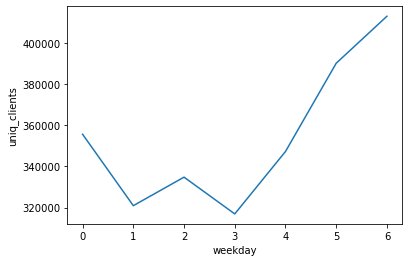

In [61]:
#График зависимости количества уникальных посетителей от дня недели

sns.lineplot(x = 'weekday', y = 'uniq_clients', data = n_clients_per_weekday)

Создадим новую колонку **n_week**, которая говорит о том, какая идет неделя по счету с момента первой покупки, она же и характеризует период в который покупка была совершена.

In [62]:
# конец i-й недели с момента первой покупки в таймстемпах
weeks = []
for i in range(1,10):
    weeks.append(i*60*60*24*7)

In [63]:
def n_week(x):
    return np.where(x <= weeks[0], 'week_1', 
                    np.where(x <= weeks[1], 'week_2', 
                             np.where(x <= weeks[2], 'week_3', 
                                      np.where(x <= weeks[3],'week_4',
                                               np.where(x <= weeks[4], 'week_5',
                                                       np.where(x <= weeks[5], 'week_6',
                                                               np.where(x <= weeks[6], 'week_7',
                                                                       np.where(x <= weeks[7], 'week_8','week_9')))))))).item()

In [64]:
n_week_udf = udf(n_week,StringType())


Создадим вспомогательный df, который отбражает количество визитов покупателя в каждый период

In [65]:
n_week_visits = transactions_train\
                            .withColumn('n_week',n_week_udf(F.col('unix') - F.col('first_visit')).cast(StringType()))\
                            .dropDuplicates(['client_id','chq_id'])\
                            .orderBy('n_week')\
                            .groupby('client_id')\
                            .pivot('n_week')\
                            .agg(F.count('unix').alias('n_week_visits'))\
                            .fillna(0)\
                            .toPandas()

Создадим вспомогательный df, который отбражает средний чек покупателя в каждый период

In [66]:
n_week_avg_bill= transactions_train\
                            .withColumn('n_week',n_week_udf(F.col('unix') - F.col('first_visit')).cast(StringType()))\
                            .groupby('client_id','n_week','chq_id')\
                            .agg(F.sum('sales_sum').alias('sales_chq'))\
                            .orderBy('n_week')\
                            .groupby('client_id')\
                            .pivot('n_week')\
                            .agg(F.mean('sales_chq').alias('n_week_avg_bill'))\
                            .fillna(0)\
                            .toPandas()

Создадим колонку **weeks_visits_list**, в которой содержатся все значения по периодам (последовательно) в формате list.

In [67]:
n_week_visits['weeks_visits_list'] = n_week_visits.drop('client_id', axis = 1).values.tolist()

In [68]:
n_week_visits.head(3)

,client_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,weeks_visits_list
0,f6581967d002930cefd0d01db1d9550a,1,0,0,0,1,0,0,0,1,"[1, 0, 0, 0, 1, 0, 0, 0, 1]"
1,63210675b4ee2032ac136d4135f80e53,1,1,0,2,2,2,3,3,5,"[1, 1, 0, 2, 2, 2, 3, 3, 5]"
2,743f04d049c151a97d5ce762f5d7695d,1,0,2,0,0,1,1,2,1,"[1, 0, 2, 0, 0, 1, 1, 2, 1]"


Смысл данного преобразования: в **weeks_visit_list** содержатся последовательно количество посещений в каждый из периодов. Далее мы можем апроксимировать зависимость количества посещений от периода прямой и посмотреть на коээфициент перед периодом, который отображает **tg** угла прямой. Если **tg < 0**, следовательно его посещения уменьшаются со временем, если **tg > 0** иначе. На мой взгляд, данный фактор хорошо характеризует поведение клиента за первые 63 дня. Если он все реже посещается магазин, то скорее всего он ливнет, причем чем меньше значение тангеса, тем выше вероятность больше не вернуться. Такое же преобразование сделаем с таблицей, которая отображает средний чек покупателя в зависимости от периода и посмотрим на тангенс угла прямой, которая апроксимирует зависимость среднего чека от периода. Если средний чек у клиента сильно падает со временем, то он вероятнее всего ливнет

In [69]:
# Функция, которая считается tg угла прямой, которая апроксимирует зависимость количества визитов в магазин / средний чек
# от периода с момента первой покупки
from sklearn.linear_model import LinearRegression

def tg(y_val):
    x = np.array([1,2,3,4,5,6,7,8,9]).reshape(-1,1)
    y = np.array(y_val).reshape(-1,1)
    lin_reg = LinearRegression(n_jobs = -1)
    lin_reg.fit(x,y)
    return lin_reg.coef_[0]

In [70]:
n_week_visits['tg_visits'] = n_week_visits['weeks_visits_list'].apply(tg).apply(lambda x: x[0])

In [71]:
n_week_visits.head(3)

,client_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,weeks_visits_list,tg_visits
0,f6581967d002930cefd0d01db1d9550a,1,0,0,0,1,0,0,0,1,"[1, 0, 0, 0, 1, 0, 0, 0, 1]",1.433292e-17
1,63210675b4ee2032ac136d4135f80e53,1,1,0,2,2,2,3,3,5,"[1, 1, 0, 2, 2, 2, 3, 3, 5]",4.666667e-01
2,743f04d049c151a97d5ce762f5d7695d,1,0,2,0,0,1,1,2,1,"[1, 0, 2, 0, 0, 1, 1, 2, 1]",8.333333e-02


Преобразование для таблицы **n_week_avg_bill**

In [72]:
n_week_avg_bill['weeks_avg_bill_list'] = n_week_avg_bill.drop('client_id',axis = 1).values.tolist()

In [73]:
n_week_avg_bill.head(3)

,client_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,weeks_avg_bill_list
0,175e8899a277ea1ae629fe5da11008fc,3243.5,0.0,0.0,3252.0,0.0,0.0,0.0,0.0,0.0,"[3243.4999999999995, 0.0, 0.0, 3252.0000000000..."
1,19c9b6cd88a4d6370beedfde8a1c210d,212.5,0.0,0.0,0.0,0.0,45.0,309.0,0.0,0.0,"[212.5, 0.0, 0.0, 0.0, 0.0, 45.0, 309.0, 0.0, ..."
2,2d44e3366f6b005bb192a24df4bf8daf,705.0,0.0,135.5,269.5,376.0,235.0,132.0,0.0,241.0,"[705.0, 0.0, 135.5, 269.5, 376.0, 235.0, 132.0..."


In [74]:
n_week_avg_bill['tg_avg_bill'] = n_week_avg_bill['weeks_avg_bill_list'].apply(tg).apply(lambda x: x[0])

In [75]:
n_week_avg_bill.head(3)

,client_id,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,weeks_avg_bill_list,tg_avg_bill
0,175e8899a277ea1ae629fe5da11008fc,3243.5,0.0,0.0,3252.0,0.0,0.0,0.0,0.0,0.0,"[3243.4999999999995, 0.0, 0.0, 3252.0000000000...",-270.433333
1,19c9b6cd88a4d6370beedfde8a1c210d,212.5,0.0,0.0,0.0,0.0,45.0,309.0,0.0,0.0,"[212.5, 0.0, 0.0, 0.0, 0.0, 45.0, 309.0, 0.0, ...",-3.116667
2,2d44e3366f6b005bb192a24df4bf8daf,705.0,0.0,135.5,269.5,376.0,235.0,132.0,0.0,241.0,"[705.0, 0.0, 135.5, 269.5, 376.0, 235.0, 132.0...",-31.625000


Создадим df = **tg_visits_avg_bill** в котором содержатся данные, которые отображают динамику поведения среднего чека и количества посещений покупателя за первые 63 дня с момента первой покупки. (Объединили **n_week_avg_bill** & **n_week_visits** и вытащили интересующие значения)

In [76]:
tg_visits_avg_bill = n_week_avg_bill[['client_id','tg_avg_bill']]\
                                .merge(n_week_visits[['client_id','tg_visits']], on = 'client_id', how = 'left')

In [77]:
tg_visits_avg_bill.head(3)

,client_id,tg_avg_bill,tg_visits
0,175e8899a277ea1ae629fe5da11008fc,-270.433333,-0.150000
1,19c9b6cd88a4d6370beedfde8a1c210d,-3.116667,-0.083333
2,2d44e3366f6b005bb192a24df4bf8daf,-31.625000,0.216667


**Сгенерируем еще несколько признаков**.

**no_8_week:** **1**, если клиент не посещал магазин последние 8 недель, **0** иначе (Клиент совершил первую покупку в магазине, в течении недели посетил магазин ленты минимум 1 раз и 8 недель не возвращался, для такого клиент фактор no_8_week = 1).

**no_7_week**: 1, если клиента нет последние 7 недель, 0 иначе (Клиент совершил первую покупку в магазине, в течении 7-14 дней посетил магазин лены с момента первой покупки минимум 1 раз и 7 недель не возращался, для такого клиента фактор no_7_week = 1). 

....

**no_1_week**: 1, если клиент посетил магазин минимум 1 раз в период 56 - 63 дней с момента первой покупки, 0 иначе

In [78]:
def no_n_week(x):
    no_zero_weeks = 0
    for i in range(1,y + 1):
        l = 10 - i
        if x[f'week_{l}'] != 0:
            no_zero_weeks += 1
    if no_zero_weeks == 0:
        return 1
    else:
        return 0

In [79]:
for y in range(2,9):
    n_week_visits[f'no_{y}_week'] = n_week_visits.apply(lambda x: no_n_week(x), axis = 1 ) 

In [80]:
columns_no_week = [f'no_{x}_week' for x in range(2,9)]

In [81]:
columns_no_week.append('client_id')

In [82]:
tg_visits_avg_bill_weeks = tg_visits_avg_bill.merge(n_week_visits[columns_no_week], on = 'client_id', how =  'left')

**tg_visits_avg_bill_weeks** конвертируем в pyspark df

In [83]:
tg_weeks_values = sqlContext.createDataFrame(tg_visits_avg_bill_weeks)

Джойн **tg_weeks_values** к **client_train**

In [84]:
client_train = client_train.join(tg_weeks_values, 'client_id','left')

In [85]:
client_train.dtypes

[('client_id', 'string'),
 ('churn', 'int'),
 ('gender', 'string'),
 ('city', 'string'),
 ('age_group', 'string'),
 ('city_store', 'string'),
 ('plant_type', 'string'),
 ('city_store_city', 'int'),
 ('tg_avg_bill', 'double'),
 ('tg_visits', 'double'),
 ('no_2_week', 'bigint'),
 ('no_3_week', 'bigint'),
 ('no_4_week', 'bigint'),
 ('no_5_week', 'bigint'),
 ('no_6_week', 'bigint'),
 ('no_7_week', 'bigint'),
 ('no_8_week', 'bigint')]

Создадим бинарную переменную **total_decrease**. 

**total_decrease = 1** если падает и средний чек и количество посещений. (**tg_avg_bill < 0** & **tg_visits < 0**)

**total_decrease = 0** иначе



In [86]:
client_train = client_train\
                    .withColumn('total_decrease',map_func((F.col('tg_avg_bill') < 0) & (F.col('tg_visits') < 0)).cast('Int'))

In [87]:
client_train.cache()

DataFrame[client_id: string, churn: int, gender: string, city: string, age_group: string, city_store: string, plant_type: string, city_store_city: int, tg_avg_bill: double, tg_visits: double, no_2_week: bigint, no_3_week: bigint, no_4_week: bigint, no_5_week: bigint, no_6_week: bigint, no_7_week: bigint, no_8_week: bigint, total_decrease: int]

In [88]:
client_train_pd = client_train.toPandas()

In [89]:
client_train_pd[['tg_avg_bill','tg_visits']] = client_train_pd[['tg_avg_bill','tg_visits']].apply(lambda x: np.round(x,3), axis = 1)

Интересно будет посмотреть на медианные значения **tg_avg_bill & tg_visits** в зависимости от churn. По моему мнению, сгенерированные фичи внесут большой вклад в модель.

In [90]:
tg_avg_bill_churn = client_train_pd\
                            .query('churn == 1')\
                            .tg_avg_bill\
                            .values

tg_avg_bill_not_churn = client_train_pd\
                            .query('churn == 0')\
                            .tg_avg_bill\
                            .values

tg_visits_churn = client_train_pd\
                            .query('churn == 1')\
                            .tg_visits\
                            .values

tg_visits_not_churn = client_train_pd\
                            .query('churn == 0')\
                            .tg_visits\
                            .values

In [91]:
# Генерация бутстрапированных выборок
def get_bootstrap_samples(data, n_samples):
    indexes = np.random.randint(0,len(data),(n_samples, len(data)))
    samples = data[indexes]
    return samples

In [92]:
# доверительный интервал
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [93]:
# медианы для сгенерированных выборок
tg_avg_bill_churn_medians = np.array(list(map(np.median,get_bootstrap_samples(tg_avg_bill_churn, 5000))))

In [94]:
tg_avg_bill_not_churn_medians = np.array(list(map(np.median,get_bootstrap_samples(tg_avg_bill_not_churn, 5000))))

In [95]:
tg_visits_churn_medians = np.array(list(map(np.median,get_bootstrap_samples(tg_visits_churn, 5000))))

In [96]:
tg_visits_not_churn_medians = np.array(list(map(np.median,get_bootstrap_samples(tg_visits_not_churn, 5000))))

In [97]:
print("Точечная оценка медианы tg_avg_bill для тех кто ушел = ",tg_avg_bill_churn_medians.mean())
print("Точечная оценка медианы tg_avg_bill для тех кто не ушел = ",tg_avg_bill_not_churn_medians.mean())


Точечная оценка медианы tg_avg_bill для тех кто ушел =  -52.70745719999999
Точечная оценка медианы tg_avg_bill для тех кто не ушел =  -38.989656200000006


In [98]:
print("Точечная оценка медианы tg_visits для тех кто ушел = ",tg_visits_churn_medians .mean())
print("Точечная оценка медианы tg_visits для тех кто не ушел = ",tg_visits_not_churn_medians.mean())

Точечная оценка медианы tg_visits для тех кто ушел =  -0.11700000000000002
Точечная оценка медианы tg_visits для тех кто не ушел =  -0.083


In [99]:
# Доверительный интервал для разности медиан tg_avg_bill
stat_intervals(tg_avg_bill_churn_medians - tg_avg_bill_not_churn_medians, 0.05)


array([-15.13415, -12.306  ])

In [100]:
# Доверительный интервал для разности медиан tg_visits
stat_intervals(tg_visits_churn_medians - tg_visits_not_churn_medians, 0.05)


array([-0.034, -0.034])

Как мы видим, доверительные интервалы не включают ноль, следовательные медианные значения двух переменных в зависимости от churn различаются

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

Реализуем функцию для оценки Логистической регрессии. Также организуется трансформация переменных и фитинг модели через пайплайн, далее гридсерч с целью определить оптимальный параметр регуляризации.

In [125]:
def LR_model(X):
    
    X_train = X.drop(['churn','client_id'], axis = 1)
    y_train = X['churn']
    
    categorical_cols = X_train.select_dtypes(include = ['object']).columns.tolist()
    
    binary_cols = ['city_store_city','total_decrease'] + [f'no_{x}_week' for x in range(2,9)]
    
    numerical_cols = X_train.drop(categorical_cols + binary_cols, axis = 1).columns.tolist()
    
    LR = LogisticRegression(random_state = 20, class_weight = 'balanced', n_jobs = -1)
    
    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [        
                            #binary
                            ('binary_values', preprocessing.FunctionTransformer(lambda data: data.loc[:, binary_cols])), 

                            #numerical
                            ('numeric_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical_cols])),
                                ('scaling', preprocessing.StandardScaler())            
                                        ])),

                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:,categorical_cols ])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', LR)
                    ]
            )
    params_grid = {'model_fit__C' : np.logspace(-3,1,10)}

    LR_grid = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    LR_grid.fit(X_train, y_train)
    
    best_score = LR_grid.best_score_
    best_estimator = LR_grid.best_estimator_
    
    return [best_score, best_estimator]

Пора уже построить первую тестовую модель по сгенерированным факторам

In [103]:
LR_model_1 =  LR_model(client_train_pd)

In [104]:
print("roc auc LR_model_1 = ", LR_model_1[0])

roc auc LR_model_1 =  0.673280561371356


Как мы видим, roc auc = 0.67, попробуем использовать Случайный лес, возможно он сработает лучше

In [105]:
from sklearn.model_selection import cross_val_score

Реализуем функцию оценки Случайного леса с помощью кроссвалидации.   

In [106]:
def RF_model(X):
    X_train = X.drop(['churn','client_id'], axis = 1)
    y_train = X['churn']
    
    categorical_cols = X_train.select_dtypes(include = ['object']).columns.tolist()
    
    binary_cols = ['city_store_city','total_decrease'] + [f'no_{x}_week' for x in range(2,9)]
    
    numerical_cols = X_train.drop(categorical_cols + binary_cols, axis = 1).columns.tolist()
    
    RF = RandomForestClassifier(n_estimators = 100, random_state = 20, class_weight = 'balanced', n_jobs = -1)
    
    model = pipeline.Pipeline(steps = [ 
                    ('feature_preparation', pipeline.FeatureUnion(transformer_list = [        
                            #binary
                            ('binary_values', preprocessing.FunctionTransformer(lambda data: data.loc[:, binary_cols])), 

                            #numerical
                            ('numerical_values', preprocessing.FunctionTransformer(lambda data: data.loc[:, numerical_cols])),
                        
                            #categorical
                            ('categorical_values', pipeline.Pipeline(steps = [
                                ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, categorical_cols])),
                                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                                        ])),
                        ])),
                    ('model_fit', RF)
                    ]
            )
    
    cv_cross_scores = cross_val_score(model,X_train, y_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    return cv_cross_scores

In [107]:
RF_model_1 =  RF_model(client_train_pd)

In [108]:
print("roc auc RF_model_1 = ", RF_model_1[0])

roc auc RF_model_1 =  0.593808563331755


Как мы видим, результат оставляет желать лучшего, логистическая регрессия показала себя с более презентативной стороны, окей, попробуем побить результаты **RF_model_1 & LR_model_1**, создав новые переменные

**LR_model_1 score == 0.67**

**RF_model_1 score == 0.59**

Используем данные из transaction_train, для каждого клиента подсчитаем: 

**avg_bill** - Cредний чек  (Чем больше чек, тем больше покупатель тратит, это в какой-то мере отражает лояльность магазину)

**promo_sum** - Затраты на товары по акции

**total_sum** - Сумма денег, которую покупатель потратил за первые два месяца посещения магазина

**total_visits** - Общее количество посещений

**promo_rate** - Доля затрат на товары по акциям от общей потраченной суммы

**rate_visits_weekday {Понедельник, Вторник, Среда, Четверг, Пятница, Суббота, Воскресенье** - Посещение в дни недели в процентах от всех посещений

**n_markets** Количество уникальных магазинов, которые посетил покупатель

In [109]:
new_features_1 = transactions\
                    .select('client_id')\
                    .distinct()

#### avg_bill

In [110]:
# avg_bill

avg_bill = transactions_train\
                    .groupby(['chq_id','client_id'])\
                    .agg(F.sum('sales_sum').alias('bill'))\
                    .groupby('client_id')\
                    .agg(F.mean('bill').alias('avg_bill'))

new_features_1 = new_features_1.join(avg_bill,'client_id','left')

#### promo_sum

In [111]:
# promo_sum

promo_sum = transactions_train\
                    .filter('is_promo == 1')\
                    .groupby('client_id')\
                    .agg(F.sum('sales_sum').alias('promo_sum'))

new_features_1 = new_features_1.join(promo_sum,'client_id','left')

In [112]:
# Некоторые клиенты, не тратились на товары по скидке, следует пропуски заменить на значение 0

new_features_1 = new_features_1.fillna(0, subset = ['promo_sum'])

#### total_sum

In [113]:
# total_sum

total_sum = transactions_train\
                        .groupby('client_id')\
                        .agg(F.sum('sales_sum').alias('total_sum'))

new_features_1 = new_features_1.join(total_sum,'client_id', 'left')

#### total_visits

In [114]:
## total_visits

total_visits = transactions_train\
                        .dropDuplicates(['client_id','unix'])\
                        .groupby('client_id')\
                        .agg(F.count('client_id').alias('total_visits'))

new_features_1 = new_features_1.join(total_visits,'client_id','left')

#### rate_visits_weekday

In [115]:
# rate_visits_weekday


weekdays = ['Fri','Mon','Sat','Sun','Thu','Tue','Wed']

rate_visits_weekday = transactions_train\
                            .withColumn('weekday',date_format(to_date(col('unix').cast(TimestampType())),'E'))\
                            .dropDuplicates(['client_id','unix'])\
                            .groupby('client_id')\
                            .pivot('weekday')\
                            .agg(F.count('unix'))\
                            .join(total_visits, 'client_id','left')\
                            .fillna(0)\
                            .select('client_id',*[(F.col(weekday) / F.col('total_visits')).alias(weekday) for weekday in weekdays])\
                            .drop('total_visits')

new_features_1 = new_features_1.join(rate_visits_weekday,'client_id','left')

#### promo_rate

In [116]:
new_features_1 = new_features_1\
                        .withColumn('promo_rate',F.col('promo_sum')/F.col('total_sum'))

**n_markets**

In [132]:
n_markets = transactions_train\
                .dropDuplicates(['client_id','plant'])\
                .groupby('client_id')\
                .agg(F.count('plant').alias('n_markets'))

new_features_1 = new_features_1.join(n_markets, 'client_id','left')

**Интересно будет посмотреть на часы, в которые приходят клиенты**

In [119]:

# hour_visits

num_visits_hour = transactions\
                            .withColumn('hour',hour(col('chq_date')))\
                            .dropDuplicates(['client_id','unix'])\
                            .groupby(['client_id','hour'])\
                            .agg(F.count('hour').alias('num_hour_visits'))\
                            .toPandas()\
                            .pivot(index = 'client_id', columns = 'hour', values = 'num_hour_visits')

In [120]:
transactions.withColumn('hour',hour(col('chq_date'))).select('hour').distinct().show(4)

+----+
|hour|
+----+
|   3|
+----+



Как видно из таблицы, все клиенты совершали покупки в 3 часа и такое наврядли может произойти, скорее всего отчетность по транзакциям производится после закрытия магазина, т.е ночью.

In [133]:
new_features_1_pd = new_features_1.toPandas()

In [122]:
new_features_1_pd[new_features_1_pd.columns.drop('client_id')] = new_features_1_pd[new_features_1_pd.columns.drop('client_id')].apply(lambda x: np.round(x,3), axis = 1)

In [149]:
# Создадим новый датафрейм добавив в прежний трейн датасет новые сгенерированные факторы

client_train_pd_2 = client_train_pd.merge(new_features_1_pd, on = 'client_id', how = 'left')

In [152]:
LR_model_2 = LR_model(client_train_pd_2)

In [153]:
print("roc auc LR_model_2 = ", LR_model_2[0])

roc auc LR_model_2 =  0.7009179423247887


In [154]:
RF_model_2 = RF_model(client_train_pd_2)

In [155]:
print("roc auc RF_model_2 = ", RF_model_2[0])

roc auc RF_model_2 =  0.6986585937538955


Результат стал еще лучше, значит мы движемся в правильном направлении, добавим еще признаков, которые возможно повысят score

**LR_model_2 score = 0.7009**

**RF_model_2 score = 0.6987**

### 2.3 Material Data

Используя данные из materials data, для каждого клиента подсчитаем: 

**private_sum** - Затраты на приватные товары  

**alco_summ** - Затраты на алькогольные 

Далее все факторы **private_summ** & **alco_sum** отнормируем на **total_sum**, чтобы они отображали доли от общих затрат, соответственно **private_rate & alco_rate**

Используем также данные по иерархии товаров (1 лвл и 2 лвл). Подсчитаем количество потраченных денег на каждый вид иерархии 


In [156]:
new_features_2 = transactions\
                    .select('client_id')\
                    .distinct()

In [157]:
#alco_sum

materials = spark.read.csv('materials.csv', header=True, inferSchema=True) 

materials_is_alco = materials\
                    .filter('is_alco == 1')\
                    .select('material')

alco_sum = materials_is_alco\
                    .join(transactions_train,'material','inner')\
                    .groupby('client_id')\
                    .agg(F.sum('sales_sum').alias('alco_sum'))

new_features_2 = new_features_2.join(alco_sum,'client_id','left')

In [158]:
# private_sum

materials_is_private = materials\
                        .filter('is_private_label == 1')\
                        .select('material')

private_sum = materials_is_private\
                        .join(transactions_train,'material','inner')\
                        .groupby('client_id')\
                        .agg(F.sum('sales_sum').alias('private_sum'))

new_features_2 = new_features_2.join(private_sum,'client_id','left')

In [159]:
# Заменим пропущенные значения нулями.

new_features_2 = new_features_2.fillna(0)

In [160]:
new_features_2_pd = new_features_2.toPandas()

In [161]:
client_train_pd_3 = client_train_pd_2.merge(new_features_2_pd, on = 'client_id', how =  'left')

In [162]:
# Новые факторы, доля затрат клиента на алкогольные товары и на товары ленты
client_train_pd_3['private_rate'] = client_train_pd_3['private_sum'] / client_train_pd_3['total_sum']

client_train_pd_3['alco_rate'] = client_train_pd_3['alco_sum'] / client_train_pd_3['total_sum']

In [163]:
LR_model_3 = LR_model(client_train_pd_3)

In [164]:
print("roc auc LR_model_3 = ", LR_model_3[0])

roc auc LR_model_3 =  0.701230192249344


In [165]:
RF_model_3 = RF_model(client_train_pd_3)

In [166]:
print("roc auc RF_model_3 = ", RF_model_3[0])

roc auc RF_model_3 =  0.7007032619955577


Прирост наблюдается небольшой, что говорит о слабой значимости новых признаков

**LR_model_3 score = 0.7012**

**RF_model_3 score = 0.7007**

In [167]:
# Затраты на товары в зависимости от hier_level_1 

material_1 = materials.select('material','hier_level_1')

materials_1 =  transactions_train\
                        .join(material_1, 'material','left')\
                        .groupby('client_id')\
                        .pivot('hier_level_1')\
                        .agg(F.sum('sales_sum').alias('materials_lvl_1'))\
                        .fillna(0)\
                        .withColumnRenamed('null','null_1')

In [168]:
# Затраты на товары в зависимости от hier_level_2

material_2 = materials.select('material','hier_level_2')

materials_2 =  transactions_train\
                        .join(material_2, 'material','left')\
                        .groupby('client_id')\
                        .pivot('hier_level_2')\
                        .agg(F.sum('sales_sum').alias('materials_lvl_2'))\
                        .fillna(0)\
                        .withColumnRenamed('null','null_2')


In [169]:
new_features_3_pd = materials_1.join(materials_2,'client_id','left').toPandas()

In [170]:
# В clieте_train_pd_3 содержатся прежние факторы + новые

client_train_pd_4 = client_train_pd_3.merge(new_features_3_pd, on = 'client_id', how =  'left')

In [171]:
LR_model_4 = LR_model(client_train_pd_4)

In [172]:
print("roc auc LR_model_4 = ", LR_model_4[0])

roc auc LR_model_4 =  0.7039052892457829


In [173]:
RF_model_4 = RF_model(client_train_pd_4)

In [174]:
print("roc auc RF_model_4 = ", RF_model_4[0])

roc auc RF_model_4 =  0.7079168979243003


Прирост совсем незначителен, на последнем этапе было добавлено около 66 признаков, что дало меньше чем 0.01 roc auc. На завершающем этапе построения итоговой модели, считаю, что нет смысла их добавлять, т.к. затратно по производительности, плюс из 66 признаков, 62 имеют разреженный тип, что не очень хорошо для использования алгоритмов на основе ансамблей деревьев.

**LR_model_4 score = 0.7039**

**RF_model_4 score = 0.7079**

# <center> 3. Итоговая вероятностная модель оттока клиентов

В качестве итоговой модели, был выбран алгоритм xgboost

In [269]:
import hyperopt 
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.fmin import fmin

In [270]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [271]:
from sklearn.metrics import roc_auc_score

In [318]:
# Берем client_train_pd_3 в качестве обучающей выборки
X = client_train_pd_3.drop(['client_id','churn'], axis = 1)
y = client_train_pd_3['churn']

In [273]:
categorical = X.select_dtypes(include = ['object']).columns
numerical = X.drop(categorical, axis = 1).columns

In [274]:
X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, stratify = y, shuffle = True)

In [275]:
X_train = pd.get_dummies(X_tr, columns = categorical)
X_test = pd.get_dummies(X_ts, columns = categorical)

In [276]:
X_train.drop('city_none_city', axis = 1, inplace = True)

In [282]:
def score(params):
    print("training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    weights = np.zeros(len(y_train))
    weights[y_train == 0] = 1
    weights[y_train == 1] = 2.6
    dtrain = xgb.DMatrix(X_train, y_train, weight = weights)
    dvalid = xgb.DMatrix(X_test, y_test)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid)
    score = -roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss':score, 'status':STATUS_OK}
    

In [283]:
## установим eta & num_round const, далее дофитим
def optimize(trials):
    space = {
             'num_round': 100,
             'eta':0.01,
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 0.9, 0.05),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)
    return best

In [284]:
trials = Trials()
best_params = optimize(trials)
best_params

training with params:                                                                                                  
{'colsample_bytree': 0.9, 'eta': 0.01, 'eval_metric': 'auc', 'gamma': 0.55, 'max_depth': 12.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9500000000000001}
	Score -0.7061953968617921                                                                                             


training with params:                                                                                                  
{'colsample_bytree': 0.45, 'eta': 0.01, 'eval_metric': 'auc', 'gamma': 0.54, 'max_depth': 12.0, 'min_child_weight': 4.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9500000000000001}
	Score -0.7092962955853841                                                                                             


training with params:                                  

{'colsample_bytree': 0.8,
 'gamma': 0.6,
 'max_depth': 8.0,
 'min_child_weight': 5.0,
 'subsample': 0.8}

In [285]:
# подберем оптимальное значение eta
def optimize1(trials1):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': best_params['max_depth'],
             'min_child_weight': best_params['min_child_weight'],
             'subsample': best_params['subsample'],
             'gamma':best_params['gamma'],
             'colsample_bytree':best_params['colsample_bytree'] ,
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials1, max_evals=20)
    return best

In [286]:
trials1 = Trials()
best_params1 = optimize1(trials1)
best_params1

training with params:                                                                                                  
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.6, 'learning_rate': 0.015, 'max_depth': 8.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}
	Score -0.7128796890127946                                                                                             


training with params:                                                                                                  
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.6, 'learning_rate': 0.025, 'max_depth': 8.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}
	Score -0.7130761488959714                                                                                             


training with params:                                               

	Score -0.7136506614181075                                                                                             


training with params:                                                                                                  
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.6, 'learning_rate': 0.02, 'max_depth': 8.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}
	Score -0.7133324019503644                                                                                             


training with params:                                                                                                  
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.6, 'learning_rate': 0.035, 'max_depth': 8.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}
	Score -0.7131168107863428                                           

{'eta': 0.03}

In [302]:
best_params['eta'] = best_params1['eta']
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 4
best_params['silent'] = 1
best_params['max_depth'] = int(best_params['max_depth'])

In [303]:
best_params

{'colsample_bytree': 0.8,
 'gamma': 0.6,
 'max_depth': 8,
 'min_child_weight': 5.0,
 'subsample': 0.8,
 'eta': 0.03,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'nthread': 4,
 'silent': 1}

In [304]:
data = pd.get_dummies(X, columns = categorical)

In [305]:
train = xgb.DMatrix(data, y)

In [306]:
xgbCvResult = xgb.cv(best_params, train, num_boost_round=500,  
                      nfold=3, early_stopping_rounds=50, stratified = True, shuffle = True)

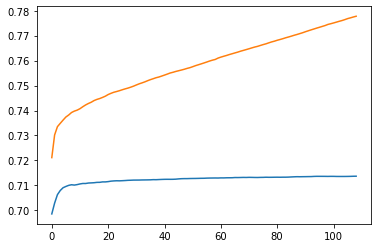

In [308]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['test-auc-mean'])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['train-auc-mean']);

In [320]:
best_num_round = np.argmax(xgbCvResult['test-auc-mean'])
best_num_round

108

In [317]:
best_auc_score = np.round(xgbCvResult['test-auc-mean'].max(),3)
best_auc_score

0.714

Для построения окончательной модели, использовался алгоритм **XGBoost**

**ROC AUC SCORE = 0.714** (Превзошел все ранее построенные модели)

In [322]:
xgb_model = xgb.train(best_params, train, best_num_round)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

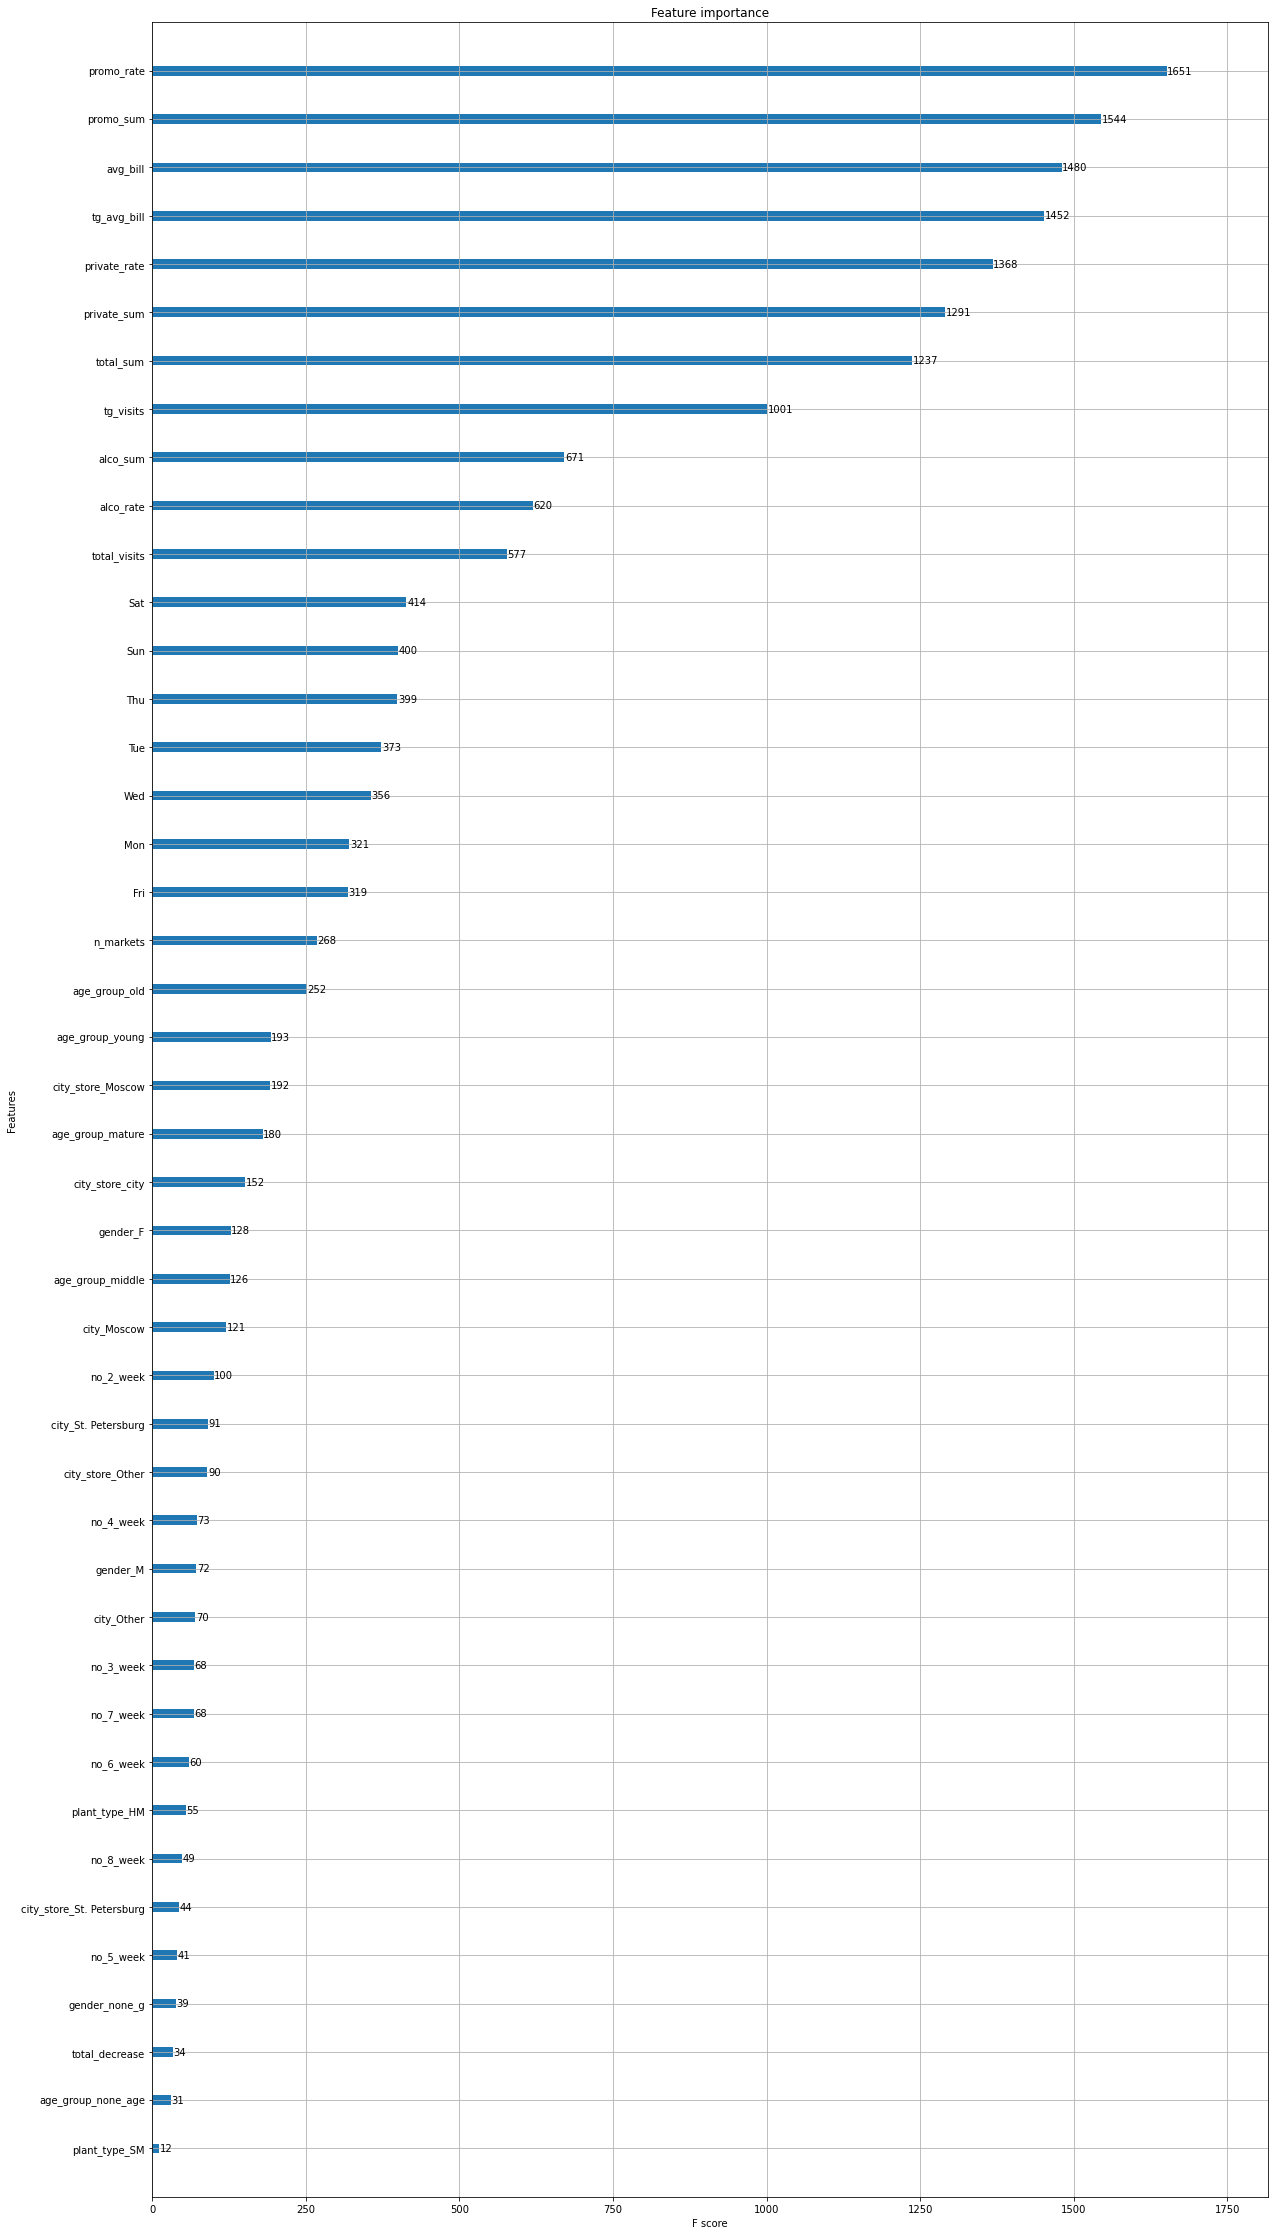

In [332]:
fig, axs = plt.subplots(figsize = (20,40))
xgb.plot_importance(xgb_model,ax = axs)

Настал момент обсудить важность признаков, выделяются среди остальных следующие:

**Top 1: promo_rate** - Доля затрат на товары по акции, неожиданный признак в топе, возможно наша продуктовая сеть особо отличается лояльной скидочной политикой, что соответсвенно привлекает клиентов -> "верный" клиент всегда будет тратится на товары по акции т.к он "шарит", это его и отличает от отточных клиентов

**Top 2: promo_sum** - Аналогично предыдущему пункту, только доля от общих затрат обладает большей информацией 

**Top 3: avg_bill** - Средний чек отражает степень лояльности покупателя, чем больше он оставляет деньги у нас, тем меньше он потратит у других. 

**Top 4: tg_avg_bill** - Скорость роста среднего чека со временем. Если он отрицательный -> покупатель все меньше готов приобретать товаров, соотв-но мы его теряем

**Top 5: private_rate** - Доля затрат на приватные товары. Отражает степень заинтересованности клиента в конкретно "нашей" сети магазинов, чем больше данный показатель, тем больше клиент потратился на уникальный товар (доступен только у нас).

**Top 6: private_sum** - Аналогично private_rate. (Доля в очередной раз имеет преимущество по информативности перед абсолютным значением)

**Top 7: total_sum** - Аналогично avg_bill
 
**Top 8: tg_visits** - Скорость роста частоты посещений. В случае, когда данный показатель отрицательный -> мы теряем клиента. 

## 4. Заключение

* Проанализировав поведение клиентов, конкретно, распределение количества дней прошедших между походами в магазин, определена стратегия идентификации отточных клиентов.
* Сгенерированы факторы для построения модели.
* Разработана модель прогнозирования вероятности оттока клиента
* Качество модели на обучающей выборке: ROC AUC = 0.714. Скор неплохой, так как данные сырые и присутствуют выбросы в наблюдениях, которые тяжело определить, например клиенты могут могут терять карту магазина и один клиент может идентифицироваться под разным ID.